# Un exemple de visualisation à partir de la variable ménage pauvre des données carroyées  (Filosofi 2015)

Dans ce notebook, nous exploitons la variable nombre de ménages pauvres *Men_pauv* contenue dans la base carroyée [filosofi 2015](https://www.insee.fr/fr/statistiques/4176290?sommaire=4176305#consulter). Sa construction et sa définition sont documentées dans ce [document méthodologique](https://www.insee.fr/fr/statistiques/fichier/4176290/documentation_DonneesCarroyees.pdf). 

### Installation des packages utilisés

In [1]:
!pip install -q -q -q geopandas
!pip install -q -q -q py7zr
!pip install -q -q -q btbpy
!pip install -q -q -q mapclassify
!pip install -q -q -q contextily

In [2]:
import os
import urllib.request
import shutil
from py7zr import unpack_7zarchive

import pandas as pd
import geopandas as gpd
import btbpy as btb
import contextily as cx

import matplotlib.pyplot as plt

## Chargement des données

Chargement de la grille de lissage à 1 km : 

In [5]:
chem_data_dir = os.path.join(os.path.dirname(btb.__file__),'data')
chem_data_grid = os.path.join(chem_data_dir, 'fr_metro_grid1km.csv')
fr_1km = pd.read_csv(chem_data_grid) #the grid

Chargement des données Filosofi carroyées 2015 :

In [6]:
url = 'https://www.insee.fr/fr/statistiques/fichier/4176290/Filosofi2015_carreaux_200m_shp.zip'
urllib.request.urlretrieve(url, 'sdf.zip')
shutil.unpack_archive('sdf.zip')
shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
shutil.unpack_archive('Filosofi2015_carreaux_200m_metropole_shp.7z', '')

In [10]:
sdf = gpd.read_file('Filosofi2015_carreaux_200m_metropole.shp')

In [11]:
Men = sdf[['IdINSPIRE','geometry', 'Depcom', 'Men', 'Men_pauv', 'Ind_snv', 'Ind']].copy()
Men['x'] = Men.geometry.centroid.x
Men['y'] = Men.geometry.centroid.y

## Densité de ménages pauvres au km² 

Il s'agit de lisser le nombre de ménages pauvres spatialement, ceci afin de conserver uniquement les informations pertinentes et de supprimer les détails inutiles. Cette opération est réalisée à l'aide du package *btbpy*. Le rayon de lissage est déterminé en fonction du territoire d'intérêt. 

In [115]:
liss_france = btb.kernelSmoothing(Men[['Men', 'Men_pauv', 'x', 'y']], '2154', 1000, 20000, fr_1km,verbose=False)
liss_france['ratio_pauvre'] = liss_france.Men_pauv / liss_france.Men * 100

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [90]:
Men_Idf = Men.loc[(Men.x > 591935) & (Men.x < 711935) & (Men.y > 6802339) & (Men.y < 6922339)].copy()
liss_Idf = btb.kernelSmoothing(Men_Idf[['Men', 'Men_pauv', 'x', 'y']], '2154', 500, 5000,verbose=False)
liss_Idf['ratio_pauvre'] = liss_Idf.Men_pauv / liss_Idf.Men * 100
liss_Idf.Men_pauv = liss_Idf.Men_pauv * 4

In [107]:
Men_Paris = Men.loc[(Men.x > 631935) & (Men.x < 676935) & (Men.y > 6842339) & (Men.y < 6882339)].copy()
liss_Paris = btb.kernelSmoothing(Men_Paris[['Men', 'Men_pauv', 'x', 'y', 'Ind_snv', 'Ind']], '2154', 200, 400,verbose=False)
liss_Paris['ratio_pauvre'] = liss_Paris.Men_pauv / liss_Paris.Men * 100
liss_Paris.Men_pauv = liss_Paris.Men_pauv * 25
liss_Paris['snv'] = liss_Paris['Ind_snv'] / liss_Paris['Ind']

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


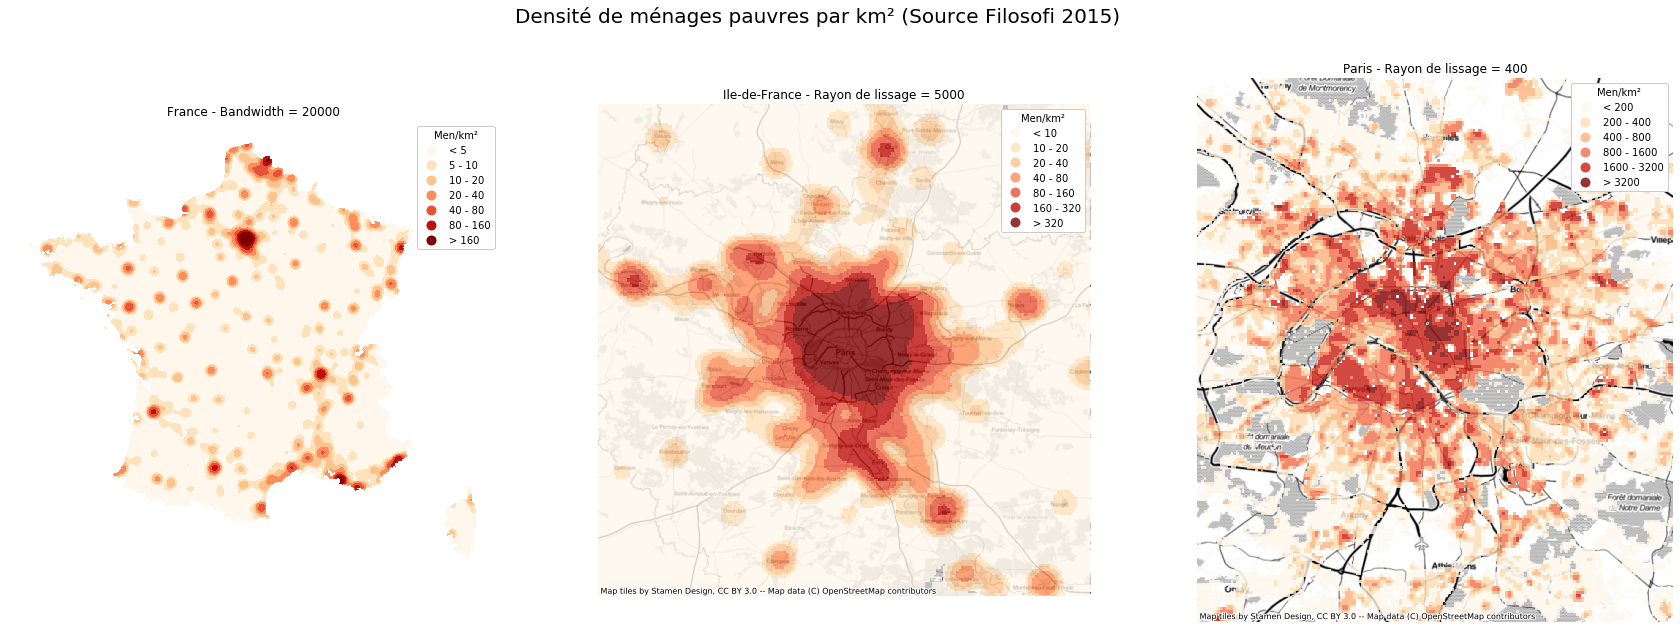

In [93]:
fig, axs = plt.subplots(ncols = 3, figsize=(30,10))
fig.suptitle("Densité de ménages pauvres par km² (Source Filosofi 2015)", fontsize=20)
bins_france = [5, 10, 20, 40, 80, 160]
bounds_france = ['< 5', '5 - 10', '10 - 20', '20 - 40', '40 - 80', '80 - 160', '> 160']

# carte France 
liss_france.plot('Men_pauv',
                      scheme='user_defined', 
                      classification_kwds={'bins': bins_france}, 
                      figsize=(10,10), 
                      cmap = 'OrRd', 
                      legend=True,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'Men/km²'},
                      ax= axs[0])
axs[0].set_axis_off()
axs[0].set_title('France - Bandwidth = 20000')

legend_labels = axs[0].get_legend().get_texts()
for bound, legend_label in zip(bounds_france, legend_labels):
    legend_label.set_text(bound)
    
# carte IDF   
bins_IDF = [10, 20, 40, 80, 160, 320]
bounds_IDF =  ['< 10', '10 - 20', '20 - 40', '40 - 80', '80 - 160', '160 - 320', '> 320']
liss_Idf.plot('Men_pauv', 
                      scheme='user_defined', 
                      classification_kwds={'bins': bins_IDF}, 
                      figsize=(10,10), 
                      cmap = 'OrRd', 
                      legend=True,
                      alpha=0.8,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'Men/km²'},
                      ax = axs[1]
                      )
axs[1].set_axis_off()
axs[1].set_xlim((651935-55000, 651935+55000))
axs[1].set_ylim((6862339-55000, 6862339+55000))
axs[1].set_title('Ile-de-France - Rayon de lissage = 5000')
cx.add_basemap(axs[1], crs=liss_Idf.crs.to_string(),source=cx.providers.Stamen.Toner)   
legend_labels = axs[1].get_legend().get_texts()
for bound, legend_label in zip(bounds_IDF, legend_labels):
    legend_label.set_text(bound)

# carte Paris
bins_Paris = [200, 400, 800, 1600, 3200]
bounds_Paris = ['< 200', '200 - 400', '400 - 800', '800 - 1600', '1600 - 3200', '> 3200']
liss_Paris.plot('Men_pauv', 
                 scheme='user_defined', 
                 classification_kwds={'bins': bins_Paris}, 
                 figsize=(10,10), 
                 cmap = 'OrRd', 
                 legend=True, 
                 alpha=0.8,
                 legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'Men/km²'},
                 ax = axs[2])
axs[2].set_axis_off()
axs[2].set_xlim((651935-15000, 651935+20000))
axs[2].set_ylim((6862339-20000, 6862339+20000))
axs[2].set_title('Paris - Rayon de lissage = 400')
cx.add_basemap(axs[2], crs=liss_Paris.crs.to_string(),source=cx.providers.Stamen.Toner)
legend_labels = axs[2].get_legend().get_texts()
for bound, legend_label in zip(bounds_Paris, legend_labels):
    legend_label.set_text(bound)

- En volume, les ménages pauvres comme toutes les sous populations se retrouvent principalement dans les espaces denses urbains ; 
- Les résultats varient selon les échelles d'analyses et les territoires d'intérêt : [Maup](https://fr.wikipedia.org/wiki/Probl%C3%A8me_d%E2%80%99agr%C3%A9gation_spatiale). 

## Analyse en proportion des ménages pauvres

Ici, on s'intéresse à la coprésence des ménages pauvres avec d'autres types de ménages à l'aide de la proportion locale de ménages pauvres. Cette proportion s'obtient en rapportant le nombre de ménages pauvres lissé au nombre de ménages lissé. Une carte des niveaux de vie compléte l'analyse. Elle est obtenue en rapportant la somme des niveaux de vie lissée au nombre de personnes lissé.

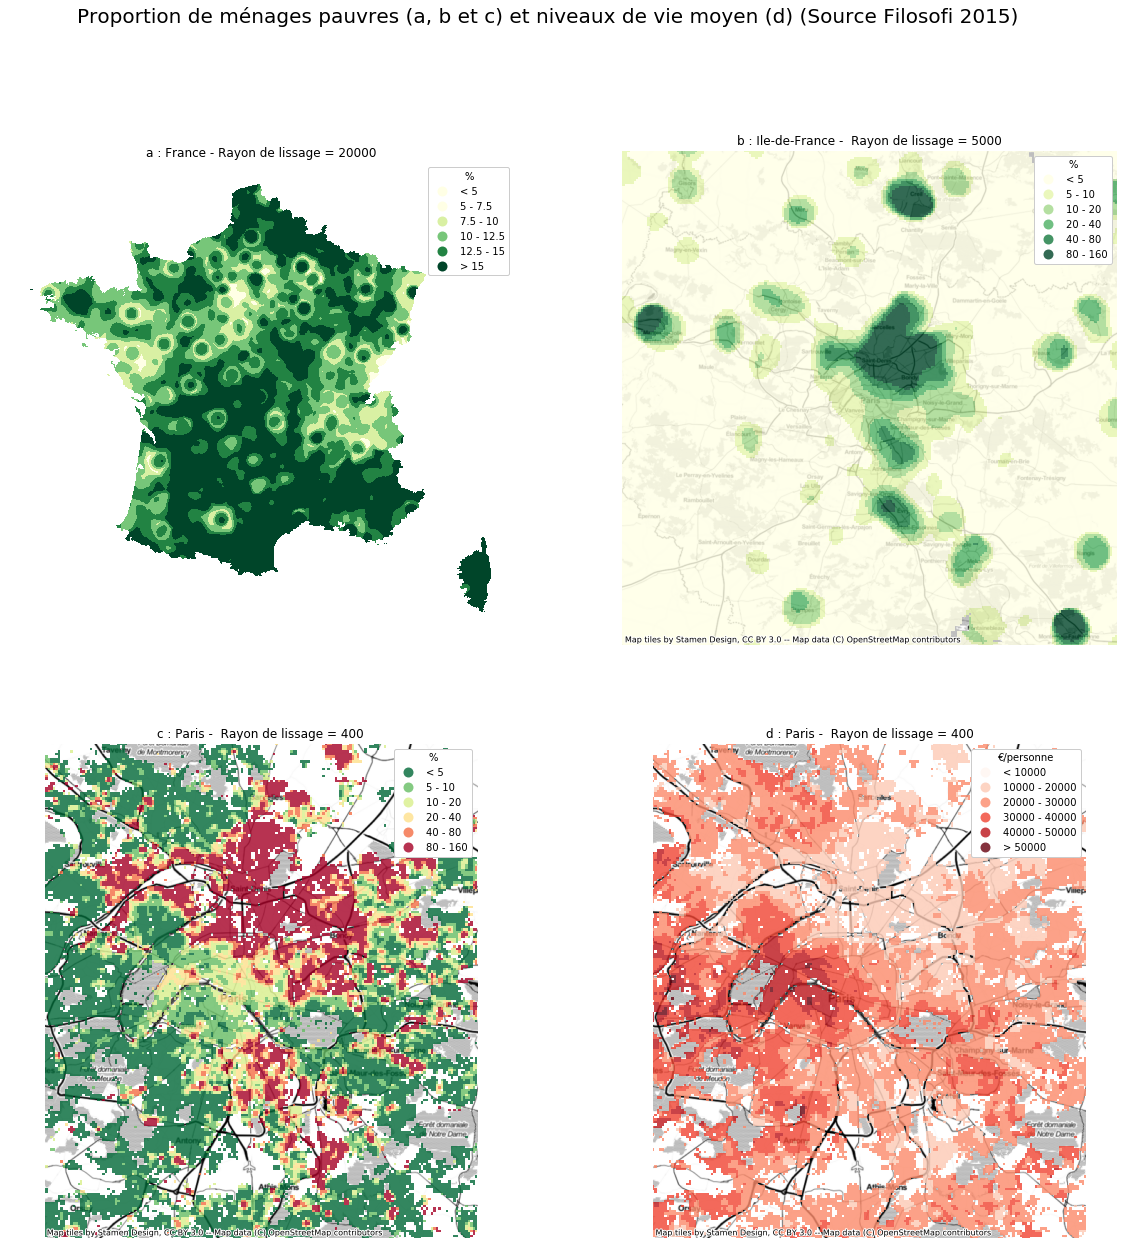

In [117]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20,20))
fig.suptitle("Proportion de ménages pauvres (a, b et c) et niveaux de vie moyen (d) (Source Filosofi 2015)", fontsize=20)

bins = [5, 7.5, 10, 12.5, 15]
bounds = ['< 5', '5 - 7.5', '7.5 - 10', '10 - 12.5', '12.5 - 15', '> 15']
liss_france.plot('ratio_pauvre', 
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'YlGn', 
                      legend=True,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'%'},
                      ax=axs[0,0])
axs[0,0].set_axis_off()
axs[0,0].set_title('a : France - Rayon de lissage = 20000')
legend_labels = axs[0,0].get_legend().get_texts()
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)

bins = [10, 12.5, 15, 17.5, 20]
bounds = ['< 10', '10 - 12.5', '12.5 - 15', '15 - 17.5', '17.5 - 20', '> 20']
liss_Idf.plot('ratio_pauvre', 
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'YlGn', 
                      legend=True,
                      alpha=0.8,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'%'},
                      ax=axs[0,1])
axs[0,1].set_axis_off()
axs[0,1].set_xlim((651935-55000, 651935+55000))
axs[0,1].set_ylim((6862339-55000, 6862339+55000))
axs[0,1].set_title('b : Ile-de-France -  Rayon de lissage = 5000')
cx.add_basemap(axs[0,1], crs=liss_Idf.crs.to_string(),source=cx.providers.Stamen.Toner)
legend_labels = axs[0,1].get_legend().get_texts()
for bound, legend_label in zip(bounds_france, legend_labels):
    legend_label.set_text(bound)

bins = [10, 12.5, 15, 17.5, 20, 100]
bounds = ['< 10', '10 - 12.5', '12.5 - 15', '15 - 17.5', '17.5 - 20', '> 20']
liss_Paris.plot('ratio_pauvre', 
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlGn_r', 
                      legend=True, 
                      alpha=0.8,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'%'},
                      ax=axs[1,0])
axs[1,0].set_axis_off()
axs[1,0].set_xlim((651935-15000, 651935+20000))
axs[1,0].set_ylim((6862339-20000, 6862339+20000))
axs[1,0].set_title('c : Paris -  Rayon de lissage = 400')
cx.add_basemap(axs[1,0], crs=liss_Paris.crs.to_string(),source=cx.providers.Stamen.Toner)
legend_labels = axs[1,0].get_legend().get_texts()
for bound, legend_label in zip(bounds_france, legend_labels):
    legend_label.set_text(bound)

bins = [10000, 20000, 30000, 40000, 50000]
bounds = ['< 10000', '10000 - 20000', '20000 - 30000', '30000 - 40000', '40000 - 50000', '> 50000']
liss_Paris.plot('snv',      
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'Reds', 
                      legend=True, 
                      alpha=0.8,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'€/personne'},
                      ax=axs[1,1])
axs[1,1].set_axis_off()
axs[1,1].set_xlim((651935-15000, 651935+20000))
axs[1,1].set_ylim((6862339-20000, 6862339+20000))
axs[1,1].set_title('d : Paris -  Rayon de lissage = 400')
cx.add_basemap(axs[1,1], crs=liss_Paris_intra.crs.to_string(),source=cx.providers.Stamen.Toner)
legend_labels = axs[1,1].get_legend().get_texts()
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)

Les centres-villes sont des espaces de coprésence de populations différentes, contrairement aux quartiers pauvres périphériques.  